In [1]:
### Imports and data ###

#Imports
import tensorflow as tf
import keras as k
import keras.backend as Kb
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import numpy as np

import datetime as dt
import matplotlib as style
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler

#Get Data from yahoo

start = dt.datetime(2001,1,1)
end = dt.datetime(2016,12,31)
df = web.DataReader('AAPL', 'yahoo', start, end)[['High','Low','Open','Close']]

#Format data for use

df = df.values.reshape(len(df), 4)
max_val = np.amax(df)
df = df/max_val

plt.plot(df[:,3])
plt.show()

data_split = 0.8
train_data = df[:int(len(df)*data_split)]
test_data = df[int(len(df)*data_split):]

Using TensorFlow backend.


<Figure size 640x480 with 1 Axes>

In [2]:
def create_ts(ds, inLen, outLen):
    X, Y = [], []
    totLen = inLen+outLen
    for i in range(len(ds)-totLen-1):
        X.append(ds[i:(i+inLen), :])
        Y.append(ds[(i+inLen):(i+totLen), 3])
    return np.array(X), np.array(Y)

in_series = 100
out_series = 22

x_train, y_train = create_ts(train_data, in_series, out_series)
x_test, y_test = create_ts(test_data, in_series, out_series)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 4))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 4))

In [3]:
#Create the model

def cust_loss(yTrue,yPred):
    difs = 0.0
    for i in range(21):
        difs += Kb.square(Kb.square(yTrue[i]-yTrue[i+1]))
    difs /= 22
    return Kb.mean(Kb.square(yTrue - yPred) + difs, axis=-1)

def cust_loss2(yTrue,yPred):
    loss = 0.0
    for i in range(21):
        difs = Kb.square(Kb.square(yTrue[i]-yTrue[i+1]))
        dif_pred = (yTrue[i]-yPred[i])**2
        loss += difs + (dif_pred * (i+1))
    loss /= 21
    loss = loss+yTrue-yTrue
    return loss

model = Sequential()

model.add(LSTM(10, input_shape=(in_series, 4)))
model.add(Dense(out_series))

opt = Adam(lr=0.01, decay=1e-6)
model.compile(loss=cust_loss2, optimizer=opt, metrics=['mse'])

In [4]:
#Fit the model to the training data

model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
3097/3097 [==============================] - 4s 1ms/step - loss: 0.0516 - mean_squared_error: 0.0040
Epoch 2/25
3097/3097 [==============================] - 3s 899us/step - loss: 0.0199 - mean_squared_error: 4.8477e-04
Epoch 3/25
3097/3097 [==============================] - 3s 909us/step - loss: 0.0200 - mean_squared_error: 4.0854e-04
Epoch 4/25
3097/3097 [==============================] - 3s 912us/step - loss: 0.0202 - mean_squared_error: 3.6384e-04
Epoch 5/25
3097/3097 [==============================] - 3s 911us/step - loss: 0.0197 - mean_squared_error: 3.5824e-04
Epoch 6/25
3097/3097 [==============================] - 3s 930us/step - loss: 0.0224 - mean_squared_error: 4.3539e-04
Epoch 7/25
3097/3097 [==============================] - 3s 909us/step - loss: 0.0205 - mean_squared_error: 3.7378e-04
Epoch 8/25
3097/3097 [==============================] - 3s 909us/step - loss: 0.0203 - mean_squared_error: 3.8400e-04
Epoch 9/25
3097/3097 [==============================] - 3s 906

In [5]:
#Predict training data

pred = model.predict(x_train)

pred = pred*max_val
train_data = train_data*max_val
y_train = y_train*max_val

print(pred[50]-y_train[50])

[-0.29732263 -0.31731343 -0.415411   -0.62130141 -0.71583384 -0.80444545
 -0.13493013 -0.24769318  0.06044018 -0.10681927 -0.18686461 -0.21298885
 -0.01586068 -0.0191772  -0.22598183 -0.14777255 -0.36470437 -0.12434256
 -0.25812852 -0.37729377 -0.2633059  -0.17665768]


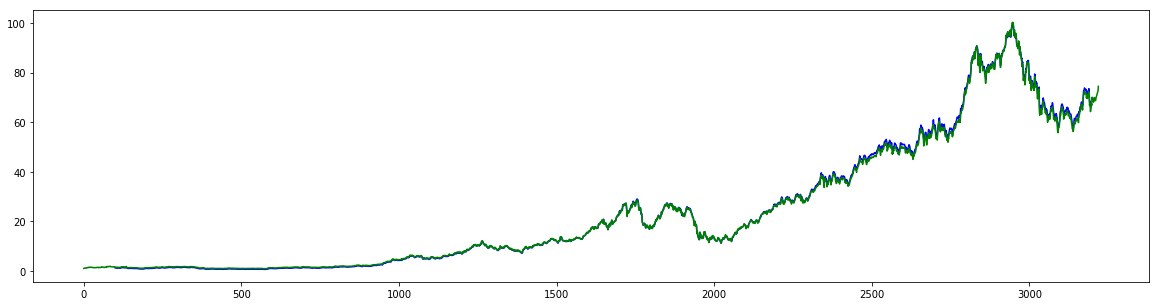

In [6]:
day = 0

plt.figure(figsize=(20,5))

plt.plot(range(99+day, train_data.shape[0]-24+day), pred[:,day], color='blue')
plt.plot(train_data[:,3], color='green')
plt.show()

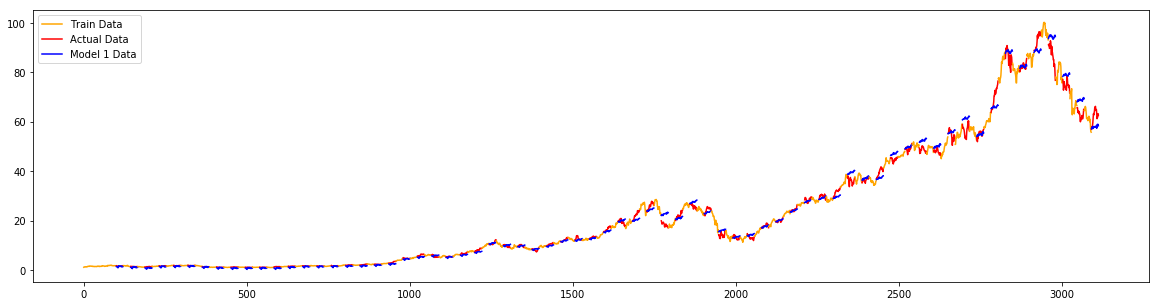

In [7]:
act_vals = 22
pred_vals = 22
tot_vals = act_vals + pred_vals

plt.figure(figsize=(20,5))

plt.plot(range(100+act_vals), train_data[:100+act_vals,3], color='orange', label='Train Data')
plt.plot(range(100, 100+pred_vals), train_data[100:100+pred_vals,3], color='red', label='Actual Data')
plt.plot(range(100, 100+pred_vals), pred[0], color='blue', label='Model 1 Data')

for x in range(100+pred_vals, x_train.shape[0]-pred_vals, tot_vals):
    plt.plot(range(x, x+act_vals), train_data[x:x+act_vals,3], color='orange')
    plt.plot(range(x+act_vals, x+tot_vals), train_data[x+act_vals:x+tot_vals,3], color='red')
    plt.plot(range(x+act_vals, x+tot_vals), pred[x-100+act_vals], color='blue')
plt.legend()
plt.show()

In [8]:
#Attempt to predict the test data

pred2 = model.predict(x_test)

pred2 = pred2*max_val
test_data = test_data*max_val
y_test = y_test*max_val

print(pred2[50]-y_test[50])

[-1.12265778 -0.3813324   0.58023071 -0.5537796  -1.5133667  -2.15750122
 -1.50341034 -2.78302002 -3.56617737 -2.88955688 -2.15853882 -1.06671143
 -2.15484619 -2.48558044 -2.21492004 -2.61406708 -1.10660553 -0.66223907
  0.1963501   0.40293121  0.03046417 -1.44625854]


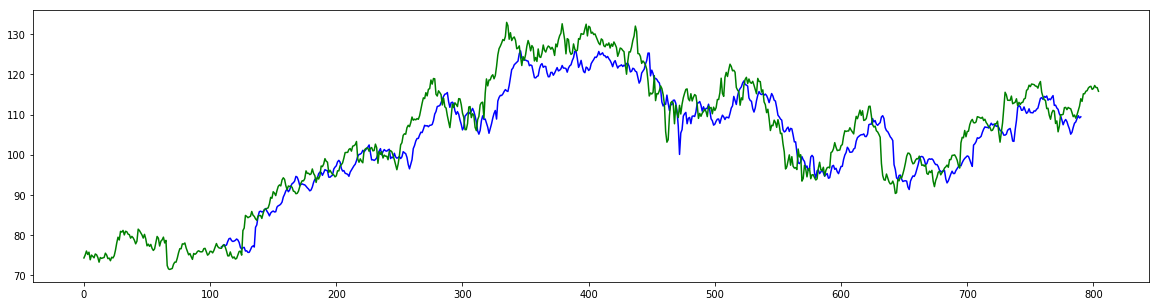

In [11]:
day = 10

plt.figure(figsize=(20,5))

plt.plot(range(99+day, test_data.shape[0]-24+day), pred2[:,day], color='blue')
plt.plot(test_data[:,3], color='green')
plt.show()

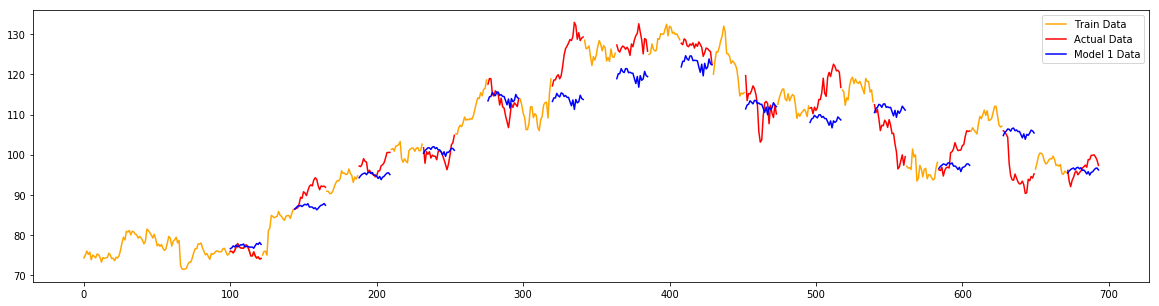

In [10]:
plt.figure(figsize=(20,5))

plt.plot(range(100+act_vals), test_data[:100+act_vals,3], color='orange', label='Train Data')
plt.plot(range(100, 100+pred_vals), test_data[100:100+pred_vals,3], color='red', label='Actual Data')
plt.plot(range(100, 100+pred_vals), pred2[0], color='blue', label='Model 1 Data')

for x in range(100+pred_vals, x_test.shape[0]-pred_vals, tot_vals):
    plt.plot(range(x, x+act_vals), test_data[x:x+act_vals,3], color='orange')
    plt.plot(range(x+act_vals, x+tot_vals), test_data[x+act_vals:x+tot_vals,3], color='red')
    plt.plot(range(x+act_vals, x+tot_vals), pred2[x-100+act_vals], color='blue')
plt.legend()
plt.show()

In [19]:
day = 21
dif = 0.0
for i in range(pred2.shape[0]):
    dif += ((pred2[i][day] - y_test[i][day])**2)**.5
dif /= pred2.shape[0]
print(dif)

6.117521123802208


In [23]:
day = 21
prob = 0.0
for i in range(pred2.shape[0]):
    dif_act = test_data[i+100][3]-test_data[i+100+day][3]
    dif_pred = pred2[i][0]-pred2[i][day]
    if ((dif_act >= 0 and dif_pred >= 0) or (dif_act < 0 and dif_pred < 0)):
        prob += 1
prob /= pred2.shape[0]
print(prob)

0.5894428152492669
